In [134]:
import re
import ast
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm
from sklearn.metrics import classification_report
tqdm.pandas()

# Parse Rewrites

In [137]:
example = pd.read_csv("../datasets/analysis/wandb_export_2023-10-10T14_40_51.216-07_00.csv")["input"].values[1]
print(example)

# parse all text between <aug> and </aug> tags
aug_regex = re.compile(r"<aug>(.*?)</aug>", re.DOTALL)
augmentations = aug_regex.findall(example)
print(augmentations)

<aug>Showtime is filled with concept comedy, but nothing can truly devalue the grinding down of bad ideas.</aug>,<aug>Bad ideas are the ultimate debasement of a concept comedy, and Showtime is packed with these types of bad ideas.</aug>,<aug>The production of Showtime is a prime example of how bad ideas can be turned into something truly amazing in concept comedy.</aug>,<aug>Showtime is packed with a large number of bad ideas that are integral to its concept comedy.</aug>
['Showtime is filled with concept comedy, but nothing can truly devalue the grinding down of bad ideas.', 'Bad ideas are the ultimate debasement of a concept comedy, and Showtime is packed with these types of bad ideas.', 'The production of Showtime is a prime example of how bad ideas can be turned into something truly amazing in concept comedy.', 'Showtime is packed with a large number of bad ideas that are integral to its concept comedy.']


# Entropy Analysis

## Entropy Accuracy Curves

In [ ]:
sst5_data = pd.read_csv("../datasets/analysis/Kyle1668-boss-sentiment-bert-base-uncased-boss_sentiment-sst5-random-sst5-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
sst5_data.head()

In [ ]:
toxigen_data = pd.read_csv("../datasets/analysis/Kyle1668-boss-toxicity-bert-base-uncased-boss_toxicity-toxigen-random-toxigen-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
toxigen_data.head()

In [ ]:
agt_data = pd.read_csv("../datasets/analysis/Kyle1668-ag-news-bert-base-uncased-ag_news_twitter-random-test-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
agt_data.head()

Calculating entropy threshold scores:  70%|███████   | 14/20 [00:00<00:00, 67.43it/s]

Calculating entropy threshold scores: 100%|██████████| 20/20 [00:00<00:00, 64.13it/s]


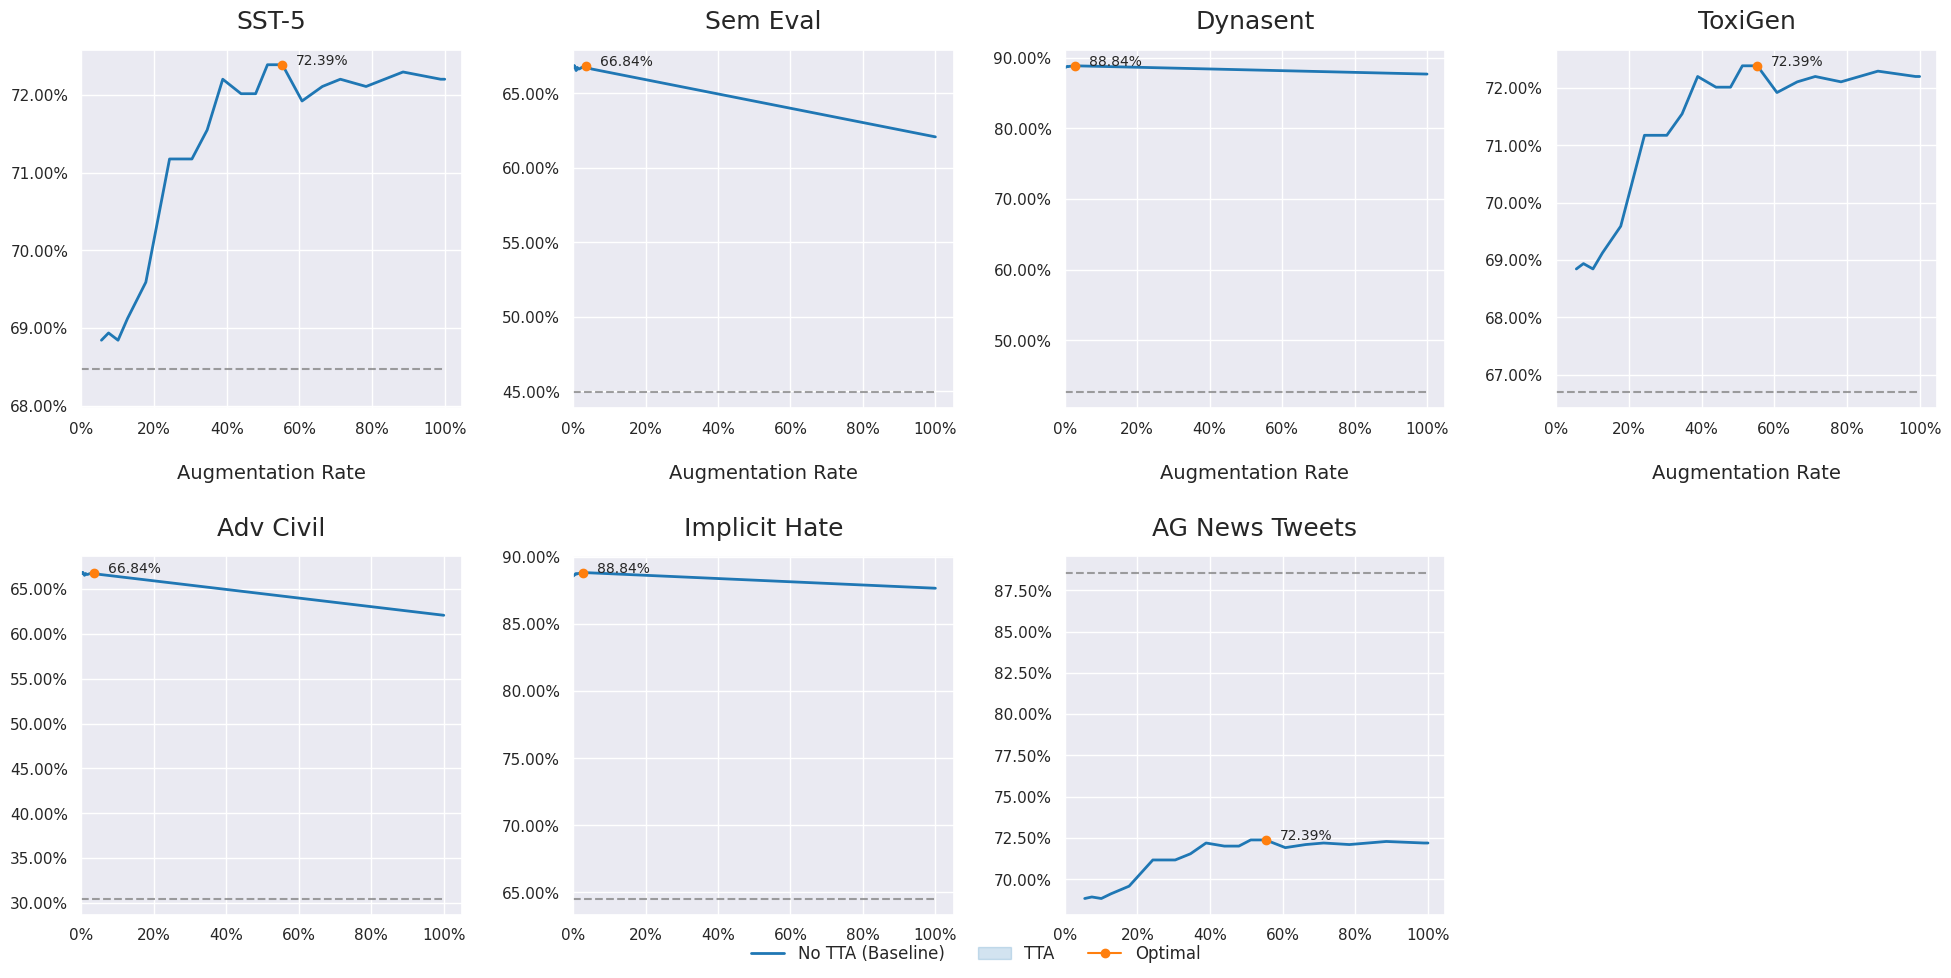

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
sns.set_style("darkgrid")

fig, axs = plt.subplots(ncols=4, figsize=(20, 10), nrows=2)

def calculate_entropy_threshold_jugments(inference_log_frame, dataset_name, half=False):
    # thresholds = np.arange(0, 1, 0.0005)
    thresholds = np.arange(0, 1, 0.05)
    threshold_scores = []
    threshold_rewrite_rates = []
    for t in tqdm(thresholds, desc="Calculating entropy threshold scores"):
        t_perf, t_rate = get_threshold_accuracy(t, inference_log_frame)
        threshold_scores.append(t_perf)
        threshold_rewrite_rates.append(t_rate)

    thresholds_frame = pd.DataFrame({"threshold": thresholds, "accuracy": threshold_scores, "rewrite_rate": threshold_rewrite_rates})

    # Set line splot
    coordinates = {
        "SST-5": (0, 0),
        "Sem Eval": (0, 1),
        "Dynasent": (0, 2),
        "ToxiGen": (0, 3),
        "Adv Civil": (1, 0),
        "Implicit Hate": (1, 1),
        "AG News Tweets": (1, 2),
    }

    # Create a line plot with the coordinates in the grid
    figure = axs[coordinates[dataset_name][0]][coordinates[dataset_name][1]]
    figure = sns.lineplot(data=thresholds_frame, x="rewrite_rate", y="accuracy", label="TTA", ax=figure)
    figure.set_title(dataset_name, fontsize=18, pad=15)
    figure.set_xlabel("Augmentation Rate" if coordinates[dataset_name][0] == 0 else "", labelpad=20, fontsize=14)
    figure.set_ylabel("Accuracy" if coordinates[dataset_name][0] == 0 == 1 else "", labelpad=20, fontsize=14)
    figure.title.set_size(18)
    figure.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
    figure.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
    figure.set_xlim(left=0)
    figure.lines[0].set_linewidth(2)
    figure.legend_.remove()

    # Display max accuracy point
    accuracy_max_point = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1].to_dict()
    figure.plot(accuracy_max_point["rewrite_rate"],
                accuracy_max_point["accuracy"],
                marker="o",
                markersize=6,
                label="Optimal",
                )
    figure.annotate(f"{accuracy_max_point['accuracy']:.2%}",
                    (accuracy_max_point["rewrite_rate"], accuracy_max_point["accuracy"]),
                    textcoords="offset points",
                    xytext=(10, 0),
                    ha="left",
                    fontsize=10)

    baseline_perf = {
        "SST-5": 0.6847,
        "Sem Eval": 0.4498,
        "Dynasent": 0.4271,
        "ToxiGen": 0.6670,
        "Adv Civil": 0.3050,
        "Implicit Hate": 0.6454,
        "AG News Tweets": 0.8857,
    }

    # plot dashed gray line representing the baseline withour augmentation
    figure.plot([0, 1], [baseline_perf[dataset_name], baseline_perf[dataset_name]], color="gray", linestyle="--", linewidth=1.5, alpha=0.75, label="No TTA (Baseline)")
    # figure.axhline(baseline_perf[dataset_name], color="gray", linestyle="--", linewidth=1.5, alpha=0.75)


    # Add padidng on the y axis if the gray line is too close to the bottom
    if dataset_name == "SST-5":
        figure.set_ylim(bottom=baseline_perf[dataset_name] - 0.005)

    # set legend outside of the graph where the gray line is "Baseline" and the blue line is "Augmented". Baseline is adashed light gray line
    # if dataset_name == "AG News Tweets":
    #     # legend should be vertical outside to the right
    #     figure.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False)
    # if dataset_name == "Implicit Hate":
        # legend should be horizontal outside to the bottom
        # figure.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), fontsize=12, frameon=False, ncol=3)

    # Display the graph
    # plt.show()

    target_threshold = None
    if half is False:
        target_threshold = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1]
    else:
        thresholds_deltas_list = abs(thresholds_frame["rewrite_rate"] - 50).tolist()
        closest_half_delta = min(thresholds_deltas_list)
        closest_threshold_index = thresholds_deltas_list.index(closest_half_delta)
        target_threshold = thresholds_frame.iloc[closest_threshold_index]

    rewrite_rate = target_threshold["rewrite_rate"] / 100
    original_judgments = inference_log_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < target_threshold["threshold"] else row["judgment"], axis=1)
    return original_judgments, rewrite_rate


def get_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < threshold else row["judgment"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True)
    llm_call_count = (inference_logs_frame["original entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate



calculate_entropy_threshold_jugments(sst5_data, "SST-5")
calculate_entropy_threshold_jugments(toxigen_data, "Sem Eval")
calculate_entropy_threshold_jugments(agt_data, "Dynasent")
calculate_entropy_threshold_jugments(sst5_data, "ToxiGen")
calculate_entropy_threshold_jugments(toxigen_data, "Adv Civil")
calculate_entropy_threshold_jugments(agt_data, "Implicit Hate")
calculate_entropy_threshold_jugments(sst5_data, "AG News Tweets")

# don't display subplots without data
# fig.delaxes(axs[2, 1])
# fig.delaxes(axs[2, 2])
fig.delaxes(axs[1, -1])
# plot legend with no dup;icates
fig.legend(loc="lower center", fontsize=12, frameon=False, ncol=3, labels=["No TTA (Baseline)", "TTA", "Optimal"])

# have padding between rows
fig.tight_layout(pad=2.0)

fig.savefig("../datasets/analysis/acc_rewrite_curves.png", bbox_inches="tight")